In [10]:
CANCER_TYPE="HGG"

In [11]:
library(Seurat)
library(harmony)


In [39]:

data_list <- readRDS(paste0("../preprocesing/out/seurat_list_doublet_", CANCER_TYPE,".rds"))


In [41]:
library(Seurat)
library(AnnotationDbi)
library(org.Hs.eg.db)  # Change to org.Mm.eg.db for Mouse
library(dplyr)

In [42]:
convert_ensembl_to_symbol <- function(ensembl_ids, species = "hsapiens") {
  # Select the appropriate OrgDb based on species
  if (species == "hsapiens") {
    orgdb <- org.Hs.eg.db
  } else if (species == "mmusculus") {
    orgdb <- org.Mm.eg.db
  } else {
    stop("Species not supported. Please use 'hsapiens' or 'mmusculus'.")
  }
  
  # Remove version numbers from Ensembl IDs (e.g., ENSG000001234.5 -> ENSG000001234)
  ensembl_ids_clean <- sub("\\..*", "", ensembl_ids)
  
  # Map Ensembl IDs to gene symbols
  gene_symbols <- mapIds(
    orgdb,
    keys = ensembl_ids_clean,
    column = "SYMBOL",
    keytype = "ENSEMBL",
    multiVals = "first"  # Use the first symbol if multiple are found
  )
  
  return(gene_symbols)
}


In [ ]:

# Iterate through each Seurat object in selected_list
for (name in names(data_list)) {
  seurat_obj <- data_list[[name]]
  
  # Get current gene identifiers
  genes <- rownames(seurat_obj)
  
  # Check if genes are Ensembl IDs (assuming Ensembl IDs start with "ENSG")
  if (any(grepl("^ENSG", genes))) {
    message(paste("Converting Ensembl IDs to gene symbols in", name))
    
    # Convert Ensembl IDs to gene symbols
    gene_symbols <- convert_ensembl_to_symbol(genes, species = "hsapiens")  # Change species if needed
    
    # Identify genes with valid gene symbols
    valid_genes <- !is.na(gene_symbols) & gene_symbols != ""
    
    if (sum(valid_genes) == 0) {
      warning(paste("No valid gene symbols found for", name, ". Skipping this object."))
      next
    }
    
    # Subset Seurat object to keep only valid genes
    seurat_obj_subset <- subset(seurat_obj, features = genes[valid_genes])
    gene_symbols_subset <- gene_symbols[valid_genes]
    
    # Get the counts matrix
    counts_matrix <- GetAssayData(seurat_obj_subset, slot = "counts")
    
    # Replace rownames with gene symbols
    rownames(counts_matrix) <- gene_symbols_subset
    
    # Handle duplicate gene symbols by summing their counts
    # Convert to data frame for manipulation
    counts_df <- as.data.frame(counts_matrix)
    counts_df$gene_symbol <- rownames(counts_matrix)
    
    # Aggregate counts by gene symbol
    counts_aggregated <- counts_df %>%
      group_by(gene_symbol) %>%
      summarise(across(everything(), sum)) %>%
      ungroup()
    
    # Convert back to a matrix
    counts_matrix_aggregated <- as.matrix(counts_aggregated[,-1])
    rownames(counts_matrix_aggregated) <- counts_aggregated$gene_symbol
    
    # Create a new Seurat object with the aggregated counts
    seurat_obj_aggregated <- CreateSeuratObject(
      counts = counts_matrix_aggregated,
      meta.data = seurat_obj_subset@meta.data,
      min.cells = 3, 
      min.features = 200
    )
    
    # Transfer additional assay data if necessary
    # For example, if you have normalized data, variable features, etc.
    # This step can be more complex depending on your specific data and requirements
    
    # Replace the original Seurat object with the aggregated one
    data_list[[name]] <- seurat_obj_aggregated
    message(paste("Conversion and aggregation completed for", name))
    
  } else {
    message(paste(name, "already uses gene symbols. No conversion needed."))
  }
}

In [47]:
for (name in names(data_list)) {
    data_list[[name]][["percent.mt"]] <- PercentageFeatureSet(data_list[[name]], pattern = "^MT-")
    data_list[[name]] <- subset(data_list[[name]], subset = nFeature_RNA > 200 & nFeature_RNA < 5000 & percent.mt < 20)

}

In [48]:

# Normalize data and find variable features for each Seurat object
for (name in names(data_list)) {
  data_list[[name]] <- NormalizeData(data_list[[name]], verbose = FALSE)
  data_list[[name]] <- FindVariableFeatures(data_list[[name]], selection.method = "vst", nfeatures = 2000, verbose = FALSE)
}


Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -1.9946"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 0.4986"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  4.0465e-15"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 0.090619"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -2.1927"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 0.4996"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  1.2254e-14"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other ne

In [49]:

# Select integration features
integration_features <- SelectIntegrationFeatures(object.list = data_list, nfeatures = 2000)


In [50]:

# Merge all datasets
combined <- merge(data_list[[1]], y = data_list[2:length(data_list)], 
                 add.cell.ids = names(data_list))

# Scale data and run PCA
combined <- ScaleData(combined, features = integration_features, verbose = FALSE)
combined <- RunPCA(combined, features = integration_features, verbose = FALSE)
print(combined)

An object of class Seurat 
40284 features across 13988 samples within 1 assay 
Active assay: RNA (40284 features, 2000 variable features)
 107 layers present: counts.GSM6432703_BT2016062, counts.GSM6432704_BT2018022, counts.GSM6432705_P-1190_S-1197, counts.GSM6432706_P-1569_S-1569, counts.GSM6432723_P-6117_S-8370, counts.GSM6432724_P-6166_S-8321, counts.GSM6432725_P-6240_S-8628, counts.GSM6432730_P-6292_S-8579, counts.GSM6432731_P-6308_S-8632, counts.GSM6432735_P-6337_S-8821, counts.GSM6432737_P-6431_S-8842, counts.GSM6432738_P-6519_S-9084, counts.GSM6432739_P-6640_S-9581, counts.GSM6934152_PA1, counts.GSM6934153_PA2, counts.GSM6934155_PA4, counts.GSM6934156_PA5, counts.GSM6934157_PMA1, counts.GSM7305260_834, counts.GSM7305261_868, counts.GSM7305262_905, counts.GSM7305263_910, counts.GSM7305264_954, counts.GSM7305265_968, counts.GSM7305266_1107, counts.GSM7305267_1144, counts.GSM7305268_1187, counts.GSM7305269_1190, counts.GSM7305270_1196, counts.GSM7305271_1214, counts.GSM7305272_1241

In [51]:
head(combined@meta.data)


,orig.ident,nCount_RNA,nFeature_RNA,CANCER_TYPE,RNA_snn_res.0.1,seurat_clusters,pANN,DFC,percent.mt
,<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>
GSM6432703_BT2016062_HGG.rds_GSM6432703_BT2016062_AAAGATGGTATAGGTA-1,GSM6432703,2714,988,HGG,1,1,0.21428571,Singlet,2.3949889
GSM6432703_BT2016062_HGG.rds_GSM6432703_BT2016062_AAAGCAACAGTAGAGC-1,GSM6432703,3776,1164,HGG,1,1,0.07142857,Singlet,0.9798729
GSM6432703_BT2016062_HGG.rds_GSM6432703_BT2016062_AAAGTAGGTGAGTATA-1,GSM6432703,2659,1557,HGG,0,0,0.07142857,Singlet,2.5949605
GSM6432703_BT2016062_HGG.rds_GSM6432703_BT2016062_AAAGTAGTCCGTTGCT-1,GSM6432703,3916,2040,HGG,0,0,0.07142857,Singlet,8.6057201
GSM6432703_BT2016062_HGG.rds_GSM6432703_BT2016062_AACACGTGTAAGTGGC-1,GSM6432703,2214,852,HGG,1,1,0.00000000,Singlet,3.4778681
GSM6432703_BT2016062_HGG.rds_GSM6432703_BT2016062_AACCATGGTCGGCTCA-1,GSM6432703,3567,1010,HGG,1,1,0.14285714,Singlet,1.3456686


In [53]:

# Run Harmony integration
combined <- RunHarmony(
  object = combined,
  group.by.vars = "orig.ident", 
  assay.use = "RNA",
  reduction.use = "pca",
  dims.use = 1:20,
  verbose = TRUE
)

# Run UMAP on harmony embeddings
combined <- RunUMAP(combined, reduction = "harmony", dims = 1:20)
saveRDS(combined, paste0(file = "./out/integrated_harmony_", CANCER_TYPE, ".rds"))


Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony 9/10

Harmony converged after 9 iterations

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
13:34:07 UMAP embedding parameters a = 0.9922 b = 1.112

13:34:07 Read 13988 rows and found 20 numeric columns

13:34:07 Using Annoy for neighbor search, n_neighbors = 30

13:34:08 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:34:08 Writing

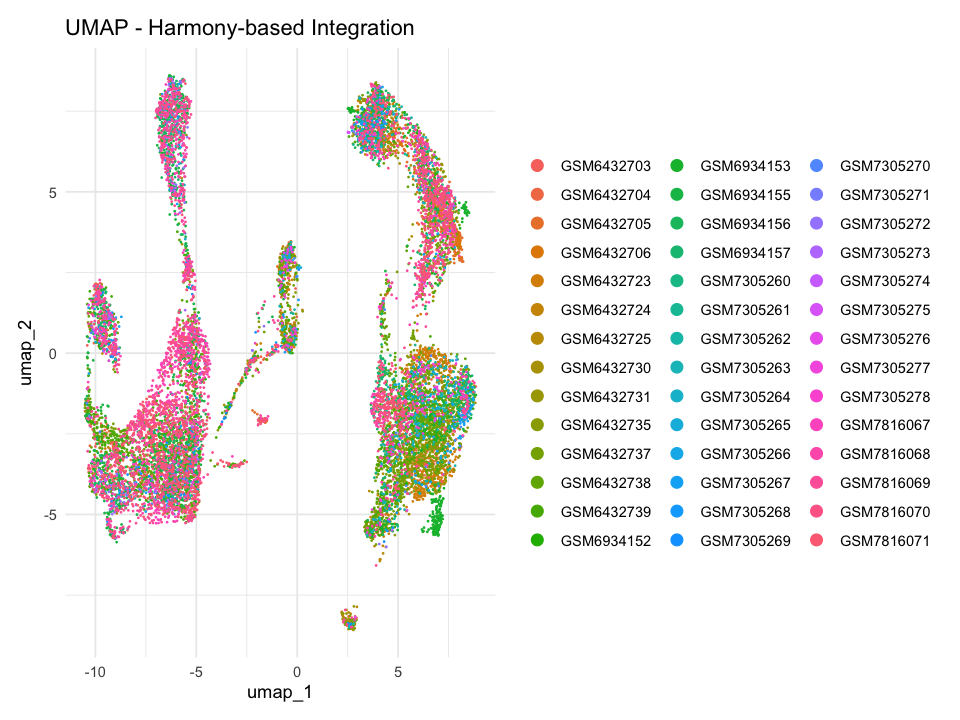

In [54]:
options(repr.plot.width=8, repr.plot.height=6)

library(ggplot2)

# Create and save UMAP plot
p <- DimPlot(combined, reduction = "umap", group.by = "orig.ident") +
  ggtitle("UMAP - Harmony-based Integration") +
  theme_minimal()

ggsave(
  filename = file.path("./out/fig", "Harmony_based_Integration_UMAP_Sample_Name.png"),
  plot = p,
  width = 8,
  height = 6
)

# Display the plot
print(p)
